In [362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [363]:
df_train = pd.read_csv('Data/train.csv')
df_test = pd.read_csv('Data/test.csv')
df_train.pop('PassengerId')
df_test.pop('PassengerId')
clear_output()

In [364]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [365]:
print(df_train.keys())

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## Get to know the data

<AxesSubplot:>

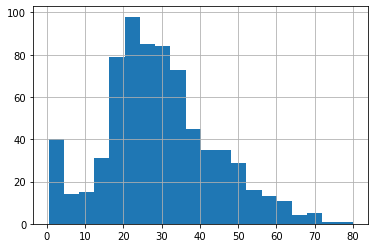

In [366]:
df_train['Age'].hist(bins=20)

<AxesSubplot:title={'center':'Classes'}, ylabel='Pclass'>

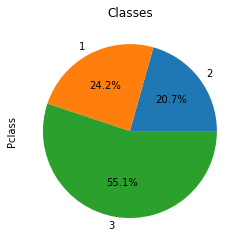

In [367]:
df_train['Pclass'].value_counts(ascending=True).plot(title='Classes', kind='pie', autopct='%1.1f%%')

<AxesSubplot:title={'center':'Sex'}>

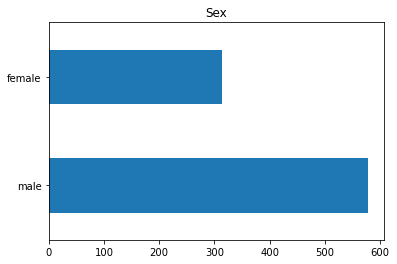

In [368]:
df_train['Sex'].value_counts().plot(title='Sex', kind='barh')

In [369]:
print('Correlation Matrix:')
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

Correlation Matrix:


,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [370]:
print(df_train['Age'].unique())

[22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.  ]


## Handling NaNs:

In [371]:
def print_NaN():
    for key in df_train.keys():
        print(f"Number of NaNs in {key}:", df_train[key].isna().sum())
        
print_NaN()

Number of NaNs in Survived: 0
Number of NaNs in Pclass: 0
Number of NaNs in Name: 0
Number of NaNs in Sex: 0
Number of NaNs in Age: 177
Number of NaNs in SibSp: 0
Number of NaNs in Parch: 0
Number of NaNs in Ticket: 0
Number of NaNs in Fare: 0
Number of NaNs in Cabin: 687
Number of NaNs in Embarked: 2


In the following we will remove the three columns "Name", "Cabin" and "Ticket", because they are not really usefull to work with. For the rest of the columns we will handle NaN values by replacing them with the mean value (for now).

In [372]:
def create_data(dataset, add_survived=False):
    X = pd.DataFrame()

    numerical_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
    categorical_colums = ['Sex', 'Embarked']
    
    #use survived column when training LR model for nans in 'Age'
    if add_survived:
        numerical_columns.extend(['Survived'])

    for feature in numerical_columns:
        X[feature] = dataset[feature]

    values = dataset['Sex'].values
    values = np.where(values=='male', 0, values)
    values = np.where(values=='female', 1, values)
    X['Sex'] = values

    X[['C','Q','S']] = pd.get_dummies(dataset['Embarked'])

    
    return X    

### first approach (alternative): using regression

In [373]:
import math
from sklearn.linear_model import LinearRegression

#process data using linearRegression for nans in 'Age'
def alternative_data(dataset):

    data = dataset
    data.drop(['Ticket', 'Cabin', 'Name'], axis=1)
    data = data.dropna(subset=['Embarked'])
    
    nan_data = pd.DataFrame(columns=data.keys())
    
    for index, row in data.iterrows():
        if math.isnan(data['Age'][index]):
            nan_data = nan_data.append(row)
            
    data = data.dropna(subset=['Age'])
    
    nans = create_data(nan_data, add_survived=True)
    X = create_data(data, add_survived=True)
    train_y = X.pop('Age')
    
    train_x = X[[ 'SibSp', 'Parch']]  
    
    
    model = LinearRegression()
    model.fit(train_x, train_y)
    
    nans.drop('Age', 1, inplace=True)
    nans['Age'] = model.predict(nans[['SibSp', 'Parch']])
    X['Age'] = train_y.values
    
    
    final_x = X.append(nans)
    final_x.sort_index(inplace=True)

    final_y = final_x.pop('Survived').astype('float')

    return final_x, final_y

In [374]:
#alternative data X and y
X_alt, y_alt = alternative_data(df_train)

In [375]:
print(X_alt.shape)
print(y_alt.shape)

(889, 9)
(889,)


### second approach: using mean of column

In [376]:
#drop irrelevant columns
X_reg = df_train.drop(['Ticket', 'Cabin', 'Name'], axis=1)

#replace NaN values
X_reg.fillna(df_train.mean(), inplace=True)

In [377]:
#droping rows with NaN values in Embarked column
print('before:', X_reg.shape)
X_reg.dropna(inplace=True)
print('after:', X_reg.shape)

before: (891, 8)
after: (889, 8)


In [378]:
X_reg = create_data(X_reg, add_survived=True)

#pop survived column
y_reg = X_reg.pop('Survived')

### Test-Train-Split:

In [379]:
from sklearn.model_selection import train_test_split

def get_tt_split(X, y):

    X_train, X_test = train_test_split(X)
    y_train, y_test = train_test_split(y)
    
    return X_train, X_test, y_train, y_test

## Model:

### Logistic Regression:

In [380]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = get_tt_split(X_reg, y_reg)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print(X_train.shape)
print(y_train.shape)


(666, 9)
(666,)


In [381]:
print('score for training data with mean:',lr.score(X_train, y_train))
print('score for test data with mean:', lr.score(X_test, y_test))

score for training data with mean: 0.6366366366366366
score for test data with mean: 0.5964125560538116


In [382]:
X_train2, X_test2, y_train2, y_test2 = get_tt_split(X_alt, y_alt)

print(X_train2.shape)
print(y_train2.shape)

lr2 = LogisticRegression(max_iter=1000)
lr2.fit(X_train2, y_train2)

(666, 9)
(666,)


LogisticRegression(max_iter=1000)

In [383]:
print('score for training data with age regression:',lr2.score(X_train2, y_train2))
print('score for test data with age regression:', lr2.score(X_test2, y_test2))

score for training data with age regression: 0.6171171171171171
score for test data with age regression: 0.6188340807174888
